In [102]:
#read in data
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import pymc as pm
import arviz as az
import os 

In [103]:
import numpy as np
import pandas as pd
import json

# Define servo indices (as you've already done)
servoIndices = {
    "NeckTilt": 0,
    "NeckPan": 1,
    "LeftEye": 2,
    "RightEye": 3,
    "LeftPupil": 4,
    "RightPupil": 5,
    "LeftArmJoint1": 6,
    "LeftArmJoint2": 7,
    "LeftArmJoint3": 8,
    "LeftArmJoint4": 9,
    "LeftArmJoint5": 10,
    "LeftHand": 11,
    "RightArmJoint1": 12,
    "RightArmJoint2": 13,
    "RightArmJoint3": 14,
    "RightArmJoint4": 15,
    "RightArmJoint5": 16,
    "RightHand": 17,
    "Body": 18
}

def parse_array(values):
    return np.array(values)

def read_data_json(file):
    # Initialize an empty DataFrame with required columns
    df = pd.DataFrame(columns=['UniqueID', 'Trajectory', 'Current', 'GyroX', 'GyroY', 'GyroZ', 'AccelX', 'AccelY', 'AccelZ'])
    
    with open(file) as f:
        data = json.load(f)
    
    # Extract data for each trajectory
    all_rows = []
    for traj in data['Trajectories']:
        unique_id = traj['UniqueID']
        trajectory = parse_array(traj['Trajectory'])
        current = parse_array(traj['Current'])
        gyro = parse_array(traj['Gyro'])
        accel = parse_array(traj['Accel'])
        
        # For each point in the trajectory, create a single row with individual values
        for i in range(len(trajectory)):
            row = {
                'UniqueID': unique_id,
                'Trajectory': trajectory[i],
                'Current': current[i],
                'GyroX': gyro[i, 0],
                'GyroY': gyro[i, 1],
                #'GyroZ': gyro[i, 2],
                'AccelX': accel[i, 0],
                'AccelY': accel[i, 1],
                #'AccelZ': accel[i, 2]
            }
            all_rows.append(row)
    
    # Create a DataFrame from the collected rows
    df = pd.DataFrame(all_rows)
    return df

# Example usage
df_2 = read_data_json("data/TrajectoriesTorso_ConsistencyTest_Increment_2.json")
df_50 = read_data_json("data/TrajectoriesTorso_ConsistencyTest_Increment_50.json")
df_2_torque = read_data_json("data/TrajectoriesTorso_ConsistencyTest_Increment_2_TorqueSearch.json")
df_50_torque = read_data_json("data/TrajectoriesTorso_ConsistencyTest_Increment_50_TorqueSearch.json")

data_names = ["2mA increment, fixed start", "50mA increment, fixed start", "2mA increment, torque", "50mA increment, torque"]

In [104]:
#filter every df to only keep trajectories that go from 237 (+/- 6) to 180 (+/- 6)
# Define the ranges for start and end positions
start_range = (231, 243)  # 237 ± 6
end_range = (174, 186)    # 180 ± 6

# Function to filter trajectories
def filter_trajectories(df):
    filtered_ids = []
    for unique_id in df['UniqueID'].unique():
        traj_data = df[df['UniqueID'] == unique_id]
        start_pos = traj_data.iloc[0]['Trajectory'][0]  # First position
        end_pos = traj_data.iloc[-1]['Trajectory'][0]   # Last position
        
        if (start_range[0] <= start_pos <= start_range[1]) and (end_range[0] <= end_pos <= end_range[1]):
            filtered_ids.append(unique_id)
            
    return df[df['UniqueID'].isin(filtered_ids)]

# Filter each dataframe
df_2 = filter_trajectories(df_2)
df_50 = filter_trajectories(df_50)
df_2_torque = filter_trajectories(df_2_torque)
df_50_torque = filter_trajectories(df_50_torque)





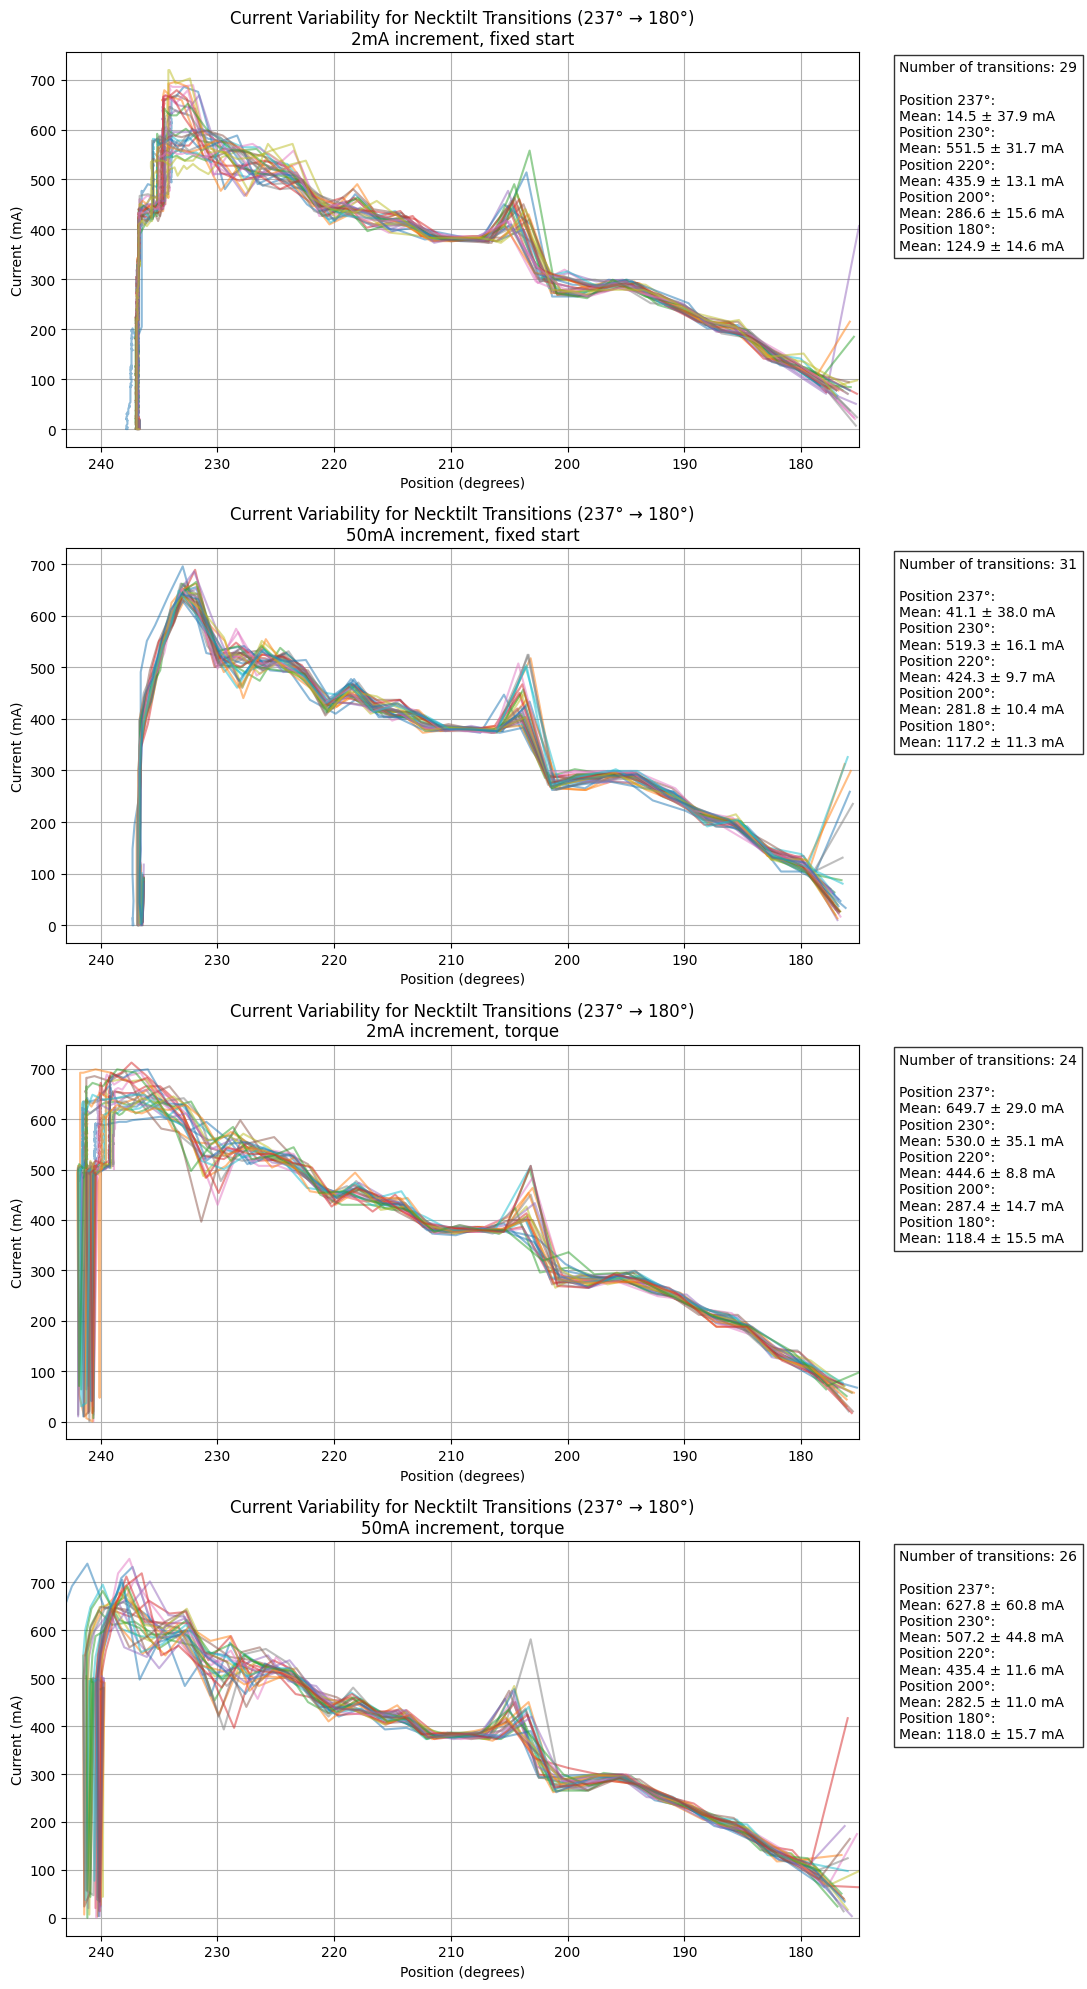

In [105]:
def plot_current_variability(dfs, data_names, ranges):

    # Create figure with subplots based on number of dataframes
    fig, axes = plt.subplots(len(dfs), 1, figsize=(11, 5*len(dfs)))
    if len(dfs) == 1:
        axes = [axes]  # Convert to list for consistent indexing
        
    for df_idx, df in enumerate(dfs):
        # Filter trajectories that go from ~237 to ~180 for Necktilt
        necktilt_transitions = []
        for unique_id in df['UniqueID'].unique():
            traj_data = df[df['UniqueID'] == unique_id]
            
            # Get first and last positions from trajectory
            start_pos = traj_data.iloc[0]['Trajectory'][0]  # First position
            end_pos = traj_data.iloc[-1]['Trajectory'][0]   # Last position
            
            # Check if trajectory goes from ~237 to ~180 (±5 degrees)
            if (ranges[0] <= start_pos <= ranges[1]) and (ranges[2] <= end_pos <= ranges[3]):
                necktilt_transitions.append(unique_id)

        # Plot current variability for this dataframe
        for transition_id in necktilt_transitions:
            transition_data = df[df['UniqueID'] == transition_id]
            current_values = [abs(curr[0]) for curr in transition_data['Current']]  # Get Necktilt current
            positions = [pos[0] for pos in transition_data['Trajectory']]      # Get Necktilt positions
            
            axes[df_idx].plot(positions, current_values, alpha=0.5, label=f'ID: {transition_id}')

        axes[df_idx].set_xlabel('Position (degrees)')
        axes[df_idx].set_ylabel('Current (mA)')
        axes[df_idx].set_title(f'Current Variability for Necktilt Transitions (237° → 180°)\n{data_names[df_idx]}')
        #axes[df_idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[df_idx].set_xlim(243, 175)
        axes[df_idx].grid(True)

        # Add statistics as text annotation
        stats_text = f"Number of transitions: {len(necktilt_transitions)}\n"
        key_positions = [237, 230, 220, 200, 180]
        for pos in key_positions:
            currents = []
            for tid in necktilt_transitions:
                tdata = df[df['UniqueID'] == tid]
                closest_idx = min(range(len(tdata)), key=lambda i: abs(tdata.iloc[i]['Trajectory'][0] - pos))
                currents.append(abs(tdata.iloc[closest_idx]['Current'][0]))
            
            stats_text += f"\nPosition {pos}°:\n"
            stats_text += f"Mean: {np.mean(currents):.1f} ± {np.std(currents):.1f} mA"
            
        axes[df_idx].text(1.05, 0.5, stats_text, transform=axes[df_idx].transAxes, 
                         bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig("plots/current_variability.png")
    plt.show()
    

plot_current_variability([df_2, df_50, df_2_torque, df_50_torque], data_names,
                         [232, 243, 175, 185])

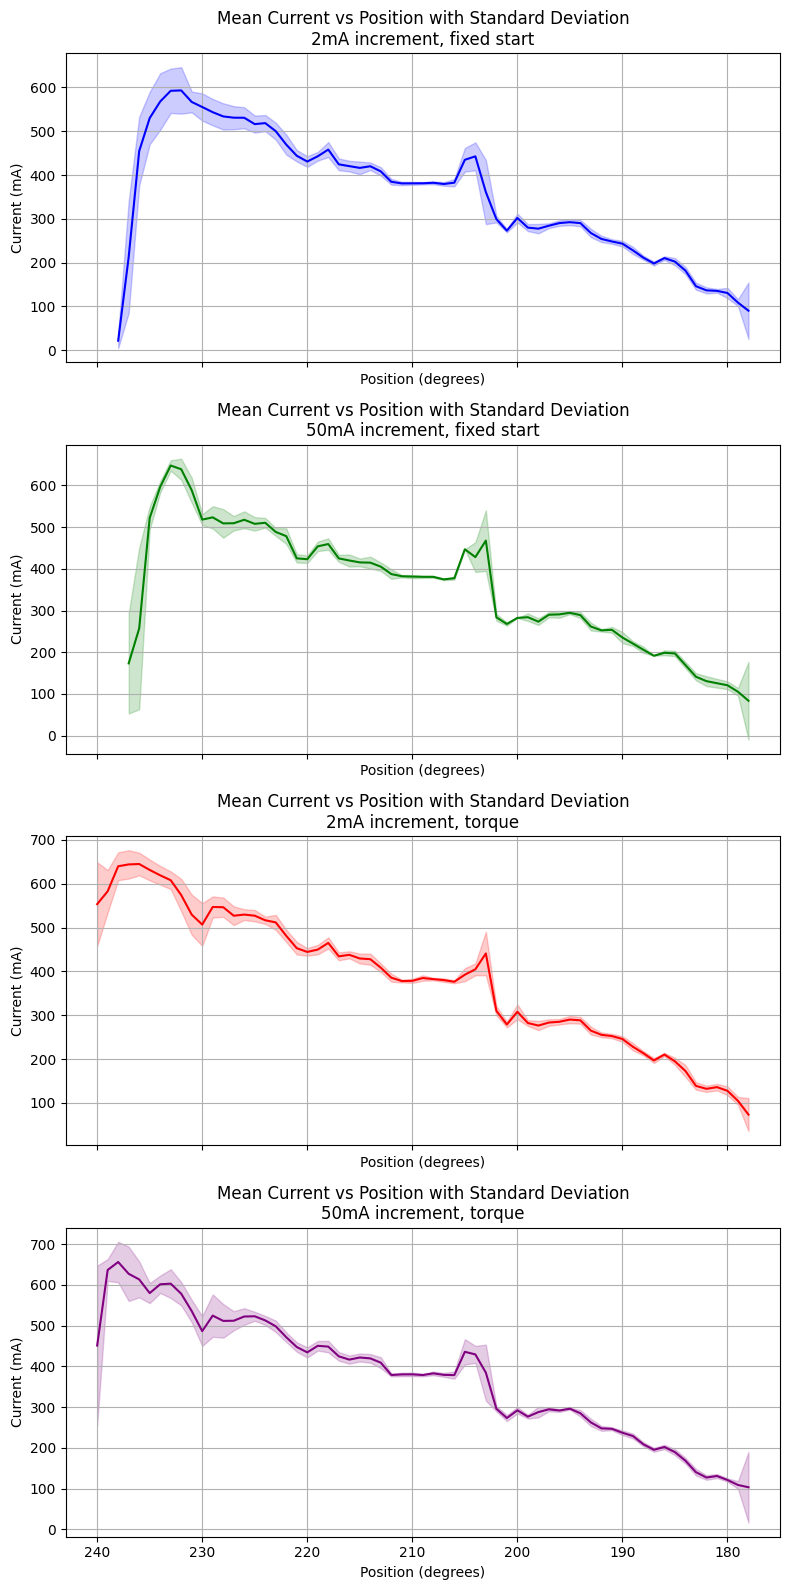

In [106]:
def plot_mean_currents_with_stats(dataframes, df_labels=None):
    """
    Plot mean currents with standard deviation for trajectories.
    
    Args:
        dataframes: List of pandas dataframes containing trajectory data
        df_labels: List of labels for each dataframe
    """
    fig, axes = plt.subplots(len(dataframes), 1, figsize=(8, 4 *len(dataframes)), sharex=True)
    if len(dataframes) == 1:
        axes = [axes]
    colors = ['blue', 'green', 'red', 'purple']
    
    for df_idx, (df, ax) in enumerate(zip(dataframes, axes)):
        # Initialize lists to store currents for each position
        positions = np.arange(240, 177, -1)  # Range from 240 to 177
        currents_by_position = {pos: [] for pos in positions}
        
        # Process each trajectory
        for unique_id in df['UniqueID'].unique():
            traj_data = df[df['UniqueID'] == unique_id]
            
            # Collect currents for each position
            for i, row in traj_data.iterrows():
                pos = row['Trajectory'][0]
                # Find closest position bin
                closest_pos = min(positions, key=lambda x: abs(x - pos))
                currents_by_position[closest_pos].append(abs(row['Current'][0]))
        
        # Calculate means and standard deviations
        means = []
        stds = []
        valid_positions = []
        
        for pos in positions:
            if currents_by_position[pos]:  # Only include positions with data
                means.append(np.mean(currents_by_position[pos]))
                stds.append(np.std(currents_by_position[pos]))
                valid_positions.append(pos)
        
        # Plot mean current with std shadow
        ax.plot(valid_positions, means, label=f'{df_labels[df_idx]}', color=colors[df_idx])
        ax.fill_between(valid_positions, 
                       np.array(means) - np.array(stds),
                       np.array(means) + np.array(stds),
                       alpha=0.2, color=colors[df_idx])
    
        ax.set_xlabel('Position (degrees)')
        ax.set_ylabel('Current (mA)')
        ax.set_title(f'Mean Current vs Position with Standard Deviation\n{df_labels[df_idx]}')
        ax.grid(True)
        ax.set_xlim(243, 175)
    
    plt.tight_layout()
    plt.savefig("plots/mean_currents_with_stats.png")
    plt.show()

# Test the function with the dataframes
plot_mean_currents_with_stats([df_2, df_50, df_2_torque, df_50_torque], 
                            data_names)


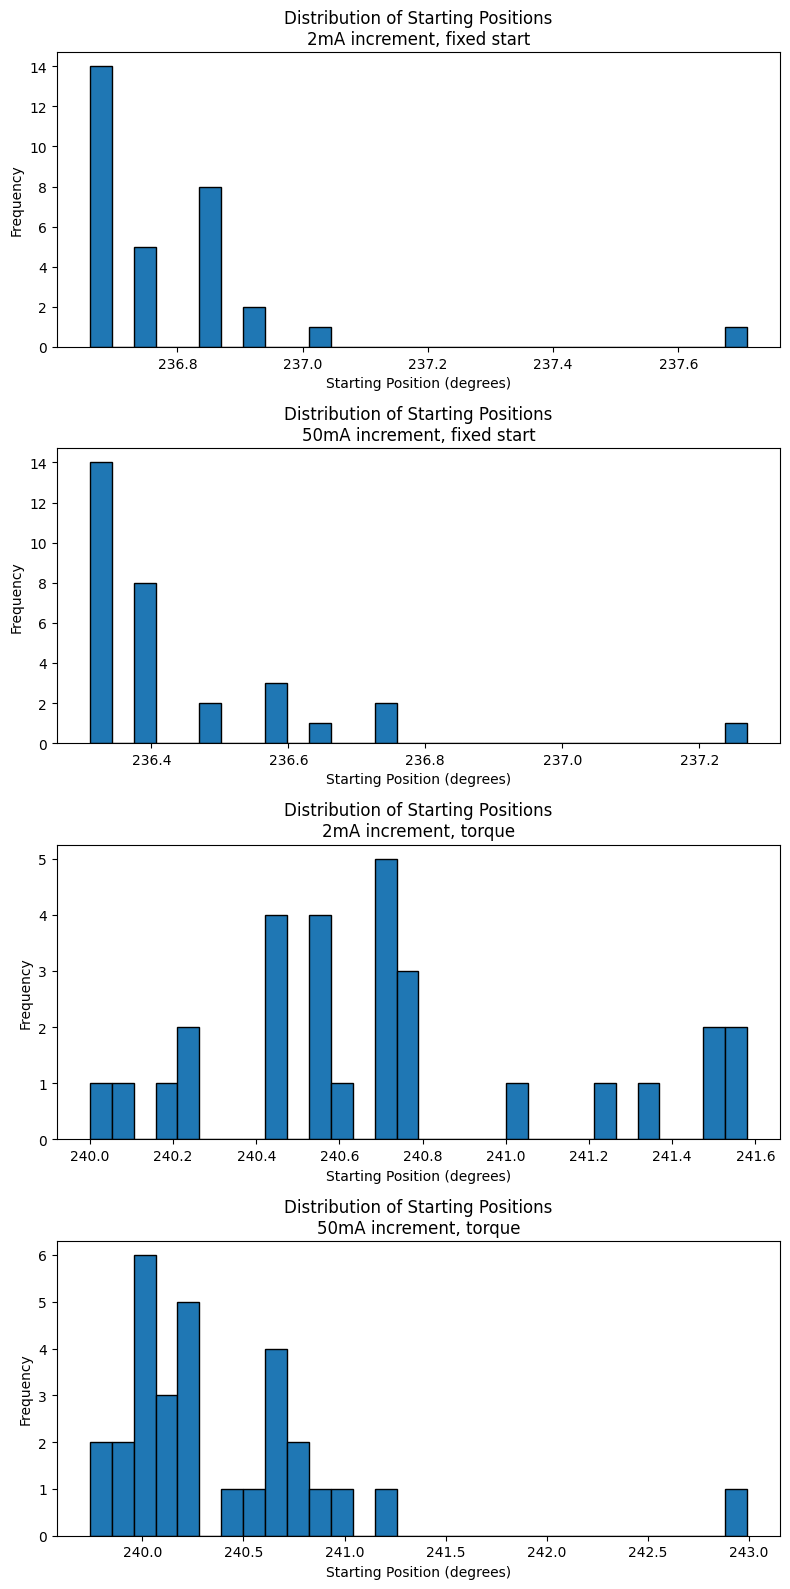

In [107]:
def start_pos_distribution(dfs, labels):
    """
    Plot the distribution of starting positions for multiple datasets.
    
    Args:
        dfs (list): List of dataframes to analyze
    """

    num_dfs = len(dfs)
    fig, axes = plt.subplots(num_dfs, 1, figsize=(8, 4*num_dfs))
    if num_dfs == 1:
        axes = [axes]
        
    for df_idx, df in enumerate(dfs):
        # Calculate starting positions for this dataset
        starting_positions = []
        for unique_id in df['UniqueID'].unique():
            trajectory_data = df[df['UniqueID']==unique_id]
            start_pos = trajectory_data.iloc[0]['Trajectory'][0]
            if start_pos > 230:
                starting_positions.append(start_pos)
        
        # Create histogram
        axes[df_idx].hist(starting_positions, bins=30, edgecolor='black')
        axes[df_idx].set_xlabel('Starting Position (degrees)')
        axes[df_idx].set_ylabel('Frequency')
        axes[df_idx].set_title(f'Distribution of Starting Positions\n{labels[df_idx]}')

    plt.tight_layout()
    plt.savefig("plots/start_pos_distribution.png")
    plt.show()
    

start_pos_distribution([df_2, df_50, df_2_torque, df_50_torque], data_names)
    

Starting Current Analysis (for trajectories starting at ~237 degrees):
--------------------------------------------------------------------------------

Dataset: 2mA increment, fixed start
Number of Valid Trajectories: 31
Average Starting Current: 545.40 mA
Standard Deviation: 29.08 mA

Dataset: 50mA increment, fixed start
Number of Valid Trajectories: 31
Average Starting Current: 519.07 mA
Standard Deviation: 23.51 mA

Dataset: 2mA increment, torque
Number of Valid Trajectories: 29
Average Starting Current: 531.00 mA
Standard Deviation: 42.60 mA

Dataset: 50mA increment, torque
Number of Valid Trajectories: 30
Average Starting Current: 509.82 mA
Standard Deviation: 53.22 mA


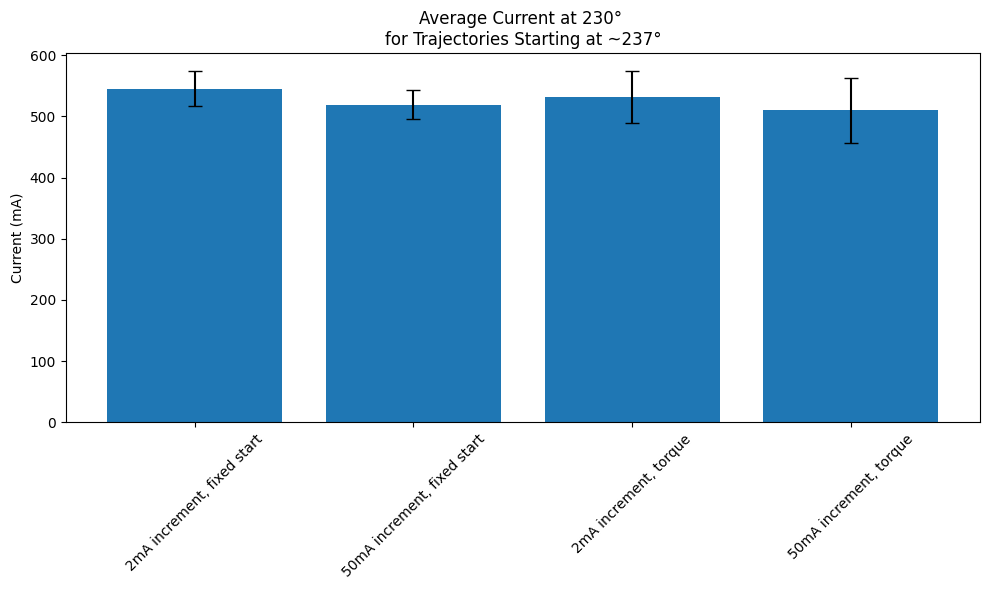

In [108]:
# Analyze Starting Current Requirements

def analyze_starting_currents(dfs, labels):
    """
    Analyze and compare the starting currents required to move servos >6 degrees across datasets.
    Only considers trajectories starting around 237 degrees.
    
    Args:
        dfs (list): List of dataframes to analyze
        labels (list): Labels for each dataset
    """
    
    results = []
    
    for df_idx, df in enumerate(dfs):
        starting_currents = []
        
        for unique_id in df['UniqueID'].unique():
            trajectory_data = df[df['UniqueID'] == unique_id]
            current_data = trajectory_data['Current'].values
            pos_data = trajectory_data['Trajectory'].values
            
            # Only analyze trajectories starting around 237 degrees (+/- 1 degree tolerance)
            start_pos = pos_data[0][0]
            if abs(start_pos - 237) <= 6:
                # Find first position change >6 degrees
                for i in range(1, len(pos_data)):
                    pos = abs(pos_data[i][0])
                    if pos <= 230:  # Movement of >4 degrees
                        starting_currents.append(abs(current_data[i][0]))
                        break
                    
        if starting_currents:  # Only calculate stats if we found valid trajectories
            avg_current = np.mean(starting_currents)
            std_current = np.std(starting_currents)
            results.append({
                'Dataset': labels[df_idx],
                'Average Starting Current (mA)': avg_current,
                'Standard Deviation (mA)': std_current,
                'Number of Trajectories': len(starting_currents)
            })
        
    # Print results
    print("Starting Current Analysis (for trajectories starting at ~237 degrees):")
    print("-" * 80)
    for result in results:
        print(f"\nDataset: {result['Dataset']}")
        print(f"Number of Valid Trajectories: {result['Number of Trajectories']}")
        print(f"Average Starting Current: {result['Average Starting Current (mA)']:.2f} mA")
        print(f"Standard Deviation: {result['Standard Deviation (mA)']:.2f} mA")
        
    # Plot comparison
    plt.figure(figsize=(10, 6))
    x = range(len(results))
    avgs = [r['Average Starting Current (mA)'] for r in results]
    stds = [r['Standard Deviation (mA)'] for r in results]
    
    plt.bar(x, avgs, yerr=stds, capsize=5)
    plt.xticks(x, [r['Dataset'] for r in results], rotation=45)
    plt.ylabel('Current (mA)')
    plt.title('Average Current at 230° \nfor Trajectories Starting at ~237°')
    plt.tight_layout()
    plt.savefig("plots/starting_currents_analysis_230deg.png")
    plt.show()
    

# Analyze the datasets
analyze_starting_currents([df_2, df_50, df_2_torque, df_50_torque], 
                        data_names)
